# Autocorrelation estimates in ROI GLMs

First part of this notebook is a direct copy of 4d

In [1]:
import nideconv
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set(style="whitegrid", font_scale=1)
# from jupyterthemes import jtplot
# jtplot.style('onedork')

import sys
import os
import pickle as pkl

import glob
import re

from nilearn import masking, plotting
import nibabel as nib

# many future warnings here, these can be annoying
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Statistics
from scipy import stats
from statsmodels.sandbox.stats import multicomp

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling 

## Utility functions

In [2]:
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', 
                   event_types=('go_trial', 'successful_stop', 'failed_stop'),
                   get_jitters=True, drop_duplicates=True):
    """ Loads all event data """
    import pandas

    if session in ['optcomb', 'me', 'PAID', 'echo_1', 'echo_2', 'echo_3', 'me-den']:
        session = 'me'
    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    if event_types is not None:
        to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)
    else:
        to_return = df

    if drop_duplicates:
        # drop duplicates (double responses on a single trial)
        to_return = to_return.drop_duplicates('onset')
    return to_return

def get_all_ts(sub, ses, run):
    if ses == 'se':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-se_run-{}_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    elif ses in ['optcomb', 'PAID']:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_comb-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses), sep='\t')
    elif 'echo_' in ses:
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me_run-{}_echo-{}_all_ts.tsv'.format(str(sub).zfill(2), run, ses[-1]), sep='\t')
    elif ses == 'me-den':
        dat = pd.read_csv('./deconvolution_cache/sub-{}_ses-me-den_run-{}_comb-optcomb_all_ts.tsv'.format(str(sub).zfill(2), run), sep='\t')
    return dat

def get_session_timeseries(ses, standardize='zscore', override_runs=None, drop_label=True):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            ts = get_all_ts(sub, ses, run)
            
            # set on common scale across runs
            if standardize == 'psc':
                ts = ts.apply(lambda x: x/np.mean(x) * 100 - 100, axis=0)
            elif standardize == 'zscore':
                ts = ts.apply(lambda x: (x-np.mean(x)) / np.std(x), axis=0)
                
            ts['subject'] = sub
            ts['run'] = run
            if drop_label:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

def get_all_onsets(ses, event_types=('go_trial', 'failed_stop', 'successful_stop', 'response_left', 'response_right')):
    onset_dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub = str(sub).zfill(2)

        for run in runs:
            onsets_this_run = get_event_data(sub, ses, run, event_types=event_types)
            onsets_this_run['subject'] = sub
            onsets_this_run['session'] = ses
            onset_dfs.append(onsets_this_run)

    onsets = pd.concat(onset_dfs)
    onsets = onsets.loc[onsets.trial_type.isin(event_types),
                        ['subject', 'session', 'run', 'trial_type', 'onset', 'duration', 'response_time']]
    onsets = onsets.set_index(['subject', 'session', 'run'])
    return onsets

In [3]:
def plot_single_mask_timecourses(rfGroup, data_type,
                                 mask_name, oversample=100, plot_type='first_level',
                                 event_types=('go_trial', 'failed_stop', 'successful_stop'),
                                 ax=None, legend='brief', add_sigma2=False):
    
    if ax is None:
        f, ax = plt.subplots(11)
        
    if data_type == 't':
        ## plot t-values
        if rfGroup.concatenate_runs:
            rfs = rfGroup._get_response_fitters(concatenate_runs=True)
            t_ = rfs.apply(lambda rf: rf.get_t_value_timecourses(oversample))
            t = pd.concat(t_.to_dict())
            index_names = t_.index.names
            t.index.set_names(index_names, level=range(len(index_names)), inplace=True)
            tc_3 = t['t'].reset_index()[['subject', 'event type', 'time', mask_name]]
            
        else:
            tc = rfGroup.get_t_value_timecourses(oversample=oversample, concatenate_runs=rfGroup.concatenate_runs).t
            tc = tc[mask_name].reset_index()

            # mean over runs
            tc_2 = tc.reset_index().rename(columns={"level_0": 'subject', 'level_1': 'session', 'level_2': 'run'})
            tc_3 = tc_2.pivot_table(values=mask_name, index=['subject', 'session', 'event type', 'time']).reset_index()
        sns.lineplot(x='time', y=mask_name, hue='event type', hue_order=event_types, data=tc_3, legend=legend, ax=ax,
                     ci=67)
    elif data_type == 'psc':
        ## plot psc or z-scores
#        group_rf = rfGroup[data_type]
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        
        if plot_type == 'first_level':
            tc = tc.loc[np.in1d(tc['event type'], event_types)]
            
            sns.lineplot(x='time', y='value', hue='event type', hue_order=event_types, 
                         data=tc.loc[tc['roi']==mask_name], 
                         legend=legend, ax=ax, ci=67)

#             sns.tsplot(data=tc.loc[tc['roi']==mask_name], 
#                        time='time', unit='subject', 
#                        condition='event type', value='value', 
#                        ax=ax, legend=legend)
        else:
            tc = tc.loc[tc.roi==mask_name]
            tc = tc.loc[np.in1d(tc['event type'], ('go_trial', 'failed_stop', 'successful_stop'))]
            tc = tc.pivot_table(values='value', index=['subject', 'time', 'covariate'], columns='event type').reset_index()
            tc['failed_stop - go_trial'] = tc['failed_stop'] - tc['go_trial']
            tc['failed_stop - successful_stop'] = tc['failed_stop'] - tc['successful_stop']
            tc['successful_stop - go_trial'] = tc['successful_stop'] - tc['go_trial']
            tc = tc.melt(id_vars=['subject', 'time'], value_vars=['failed_stop - go_trial', 'failed_stop - successful_stop', 'successful_stop - go_trial'])
            sns.lineplot(x='time', y='value', hue='event type', data=tc, legend=legend, ax=ax)
    elif data_type == 't-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        t_vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: stats.ttest_1samp(x, 0)[0]).reset_index()
        sns.lineplot(data=t_vals.loc[t_vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend)
    elif data_type == 'snr-level2':
        tc = rfGroup.get_subjectwise_timecourses(oversample=oversample, melt=True)
        tc = tc.loc[np.in1d(tc['event type'], event_types)]
        
        # t-test
        vals = tc.groupby(['event type', 'roi', 'time'])['value'].apply(lambda x: x.mean()/x.std()).reset_index()
        sns.lineplot(data=vals.loc[vals['roi']==mask_name], 
                     x='time', hue='event type', y='value', 
                     ax=ax, legend=legend, hue_order=event_types)
    
    if add_sigma2:
        sigma2 = rfGroup._get_response_fitters().apply(lambda x: x.sigma2)[mask_name]
        t = ax.text(.95, .95, '$\sigma^2 = {}\pm{}$'.format(np.mean(sigma2).round(2), np.std(sigma2).round(2)),
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='grey'))
        
    ax.axhline(y=0, c='k', ls='--')
    ax.axvline(x=0, c='k', ls='--')
    
from matplotlib import gridspec
    
def make_plot(plot_dict, data_type, columns, masks, oversample=100, plot_type='first_level', 
              y_label='% signal change', event_types=('failed_stop', 'go_trial', 'successful_stop'),
              column_titles=None, add_sigma2=False, sharey='row'):
    
    if len(columns) == 5 and not sharey == 'row':
        width_ratios = [1, 0.1, 1, 0.3, 1, .1, 1, .1, 1]
    else:
        width_ratios = [1, .15] * (len(columns)-1) + [1]
    gridspec_kws = dict(hspace=0.1, wspace=0.0, 
                        width_ratios=width_ratios)
    f, axes = plt.subplots(len(masks), len(width_ratios), gridspec_kw=gridspec_kws)

    columns_to_populate = np.arange(len(columns), dtype=int)*2
    empty_columns = [x for x in np.arange(len(width_ratios)) if not x in columns_to_populate]
    for col in empty_columns:
        for row in range(len(masks)):
            axes[row, col].axis('off')
    
#     f, axes = plt.subplots(len(masks), len(columns))
    if len(axes.shape) == 1:
        axes = axes[np.newaxis,:]

#     ax = f.add_subplot(111, frameon=False)
#     # hide tick and tick label of the big axes
# #     ax.axis('off')
#     ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
#     ax.spines["left"].set_visible(False)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.set_ylabel(y_label)
#     # ax.set_xlabel('Time from trial onset (s)')
#     ax.yaxis.labelpad = 30
#    fig.text(0.5, 0.04, 'common X', ha='center')
    f.text(0.05, 0.5, y_label, va='center', rotation='vertical')#, labelpad=30)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    # loop over the columns (j) and rows(i) to populate subplots
    for j in range(len(axes[0,:])):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[columns_to_populate.max()][0]+ext[columns_to_populate.max()][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .1, "Time from trial onset (s)", va="center", ha="center")

    # plot
    for row, mask in enumerate(masks):
        print(mask, end='')
        for col_n, session_name in zip(columns_to_populate, columns):
    
            if isinstance(oversample, list):
                oversample_ = oversample[col_n]
            else:
                oversample_ = oversample
            print('.', end='')
            plot_single_mask_timecourses(plot_dict[session_name],
                                         data_type=data_type,
                                         mask_name=mask, 
                                         ax=axes[row,col_n], 
                                         plot_type=plot_type,
                                         oversample=oversample_,
                                         event_types=event_types,
                                         add_sigma2=add_sigma2)
            if col_n > 0:
                axes[row, col_n].set_ylabel('')
            # remove xlabels except bottom row
#             if row < (len(masks)-1):
            axes[row, col_n].set_xlabel('')
        axes[row,0].set_ylabel(mask)

        if sharey == 'row':
            # get maximum ylims, set
            current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row,:]])
            for ax in axes[row,:]:
                ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])
        else:
            for sharey_columns in sharey:
                sharey_columns = [x*2 for x in sharey_columns]
                # get maximum ylims, set
                current_ranges = np.array([np.array(x.get_ylim()) for x in axes[row, sharey_columns]])
                for ax in axes[row, sharey_columns]:
                    ax.set_ylim(current_ranges.min(0)[0], current_ranges.max(0)[1])

    # Add column titles
    if column_titles is None:
        column_titles = columns
    
    for col_n, col_name in zip(columns_to_populate, column_titles):
        axes[0, col_n].set_title(col_name.replace('_', ' '))

    if plot_type == 'contrasts':
        labels = ["Failed stop - go", "Failed stop - successful stop", "Successful stop - go"]
    else:
        labels = ['Failed stop', 'Go', 'Successful stop']
        
    # remove legends except first
    for row_n in range(len(masks)):
        for col_n in columns_to_populate:
            if col_n == 4 and row_n == 0:
                axes[row_n, col_n].legend(handles=axes[row_n, col_n].lines, 
                                          labels=labels,
                                          loc=9, ncol=3, bbox_to_anchor=(.5, 1.4))
#                 axes[row_n, col_n].legend_.set_bbox_to_anchor((1, 1), transform=axes[row_n, col_n].transAxes)
            else:
                axes[row_n, col_n].legend_.remove()
    
    # determine where to place/remove ticks on y-axis
    if sharey == 'row':
        keep_y_ticks = [0]
    else:
        keep_y_ticks = [x[0]*2 for x in sharey]
        
    # hide ticks/values on axes
    for col in np.arange(1, columns_to_populate.max()+1):
        if col in keep_y_ticks:
            labelleft = 'On'
        else:
            labelleft = 'Off'

        for row in range(0, len(masks)-1):
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off', labelleft=labelleft)

        # for bottom row, keep bottom labels
        axes[len(masks)-1,col].tick_params(top='off', right='off', labelleft=labelleft)

    for row in range(0, len(masks)-1):
#        axes[row, -1].tick_params(top='off', right='off', labelbottom='Off')
        for col in keep_y_ticks:
            axes[row, col].tick_params(top='off', right='off', labelbottom='Off')
    

    f.set_size_inches(len(columns)*4, len(masks)*3)
    return f, axes

In [4]:
ses_ts = {'se': {'psc': get_session_timeseries('se', standardize='psc'),
                 'zscore': get_session_timeseries('se', standardize='zscore')},
          'optcomb': {'psc': get_session_timeseries('optcomb', standardize='psc'),
                      'zscore': get_session_timeseries('optcomb', standardize='zscore')},
          'echo_1': {'psc': get_session_timeseries('echo_1', standardize='psc'),
                     'zscore': get_session_timeseries('echo_1', standardize='zscore')},
          'echo_2': {'psc': get_session_timeseries('echo_2', standardize='psc'),
                     'zscore': get_session_timeseries('echo_2', standardize='zscore')},
          'echo_3': {'psc': get_session_timeseries('echo_3', standardize='psc'),
                     'zscore': get_session_timeseries('echo_3', standardize='zscore')}}


## Fit canonical HRF with temporal derivative

In [5]:
# get motion parameters as confounds
def get_confounds_timeseries(ses, standardize='psc', override_runs=None):
    dfs = []
    for sub in range(1,19):
        if sub == 12:
            continue
        elif sub == 17:
            runs = [1,2]
        else:
            runs = [1,2,3]
        sub_str = str(sub).zfill(2)
        
        if override_runs is not None:
            runs = override_runs
            if runs[0] == 3 and sub == 17:
                continue

        for run in runs:
            if ses == 'se':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif ses == 'optcomb':
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run), sep='\t')
            elif 'echo' in ses:
                echo_n = ses[-1]
                ts = pd.read_csv('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_desc-confounds_regressors.tsv'.format(sub_str, sub_str, run, echo_n), sep='\t')
            
            ts['subject'] = sub_str
            ts['run'] = run
            if 'time' in ts.columns:
                ts.drop(labels='time', axis=1, inplace=True)
            dfs.append(ts)
            
    all_dat = pd.concat(dfs)
    all_dat['session'] = ses
    all_dat = all_dat.set_index(['subject', 'session', 'run'])
    return all_dat

In [6]:
##
#masks = ['rSTN', 'lSTN', 'rSTR', 'lSTR', 'lGPe', 'rGPe', 'lPreSMA', 'rPreSMA', 'rM1', 'rIFG']


rfGroupsCwD = {'psc': {}} #, 'zscore': {}}
for ses in ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']:
    print('Data: {}...'.format(ses), end='')
    onsets = get_all_onsets(ses=ses, event_types=('go_trial', 'successful_stop', 'failed_stop'))
    # NB: slice time correction references to TR/2, not to 0; shift onsets to align timesereis and events
    onsets['onset'] -= 1.5
    
    # exclude trials with RT > 1
    onsets['rt'] = onsets['response_time'] - onsets['onset'] - 1.5
    onsets = onsets.loc[~((onsets['rt'] > 1) & (onsets['trial_type'] != 'successful_stop'))]
    del onsets['duration']
    del onsets['response_time']
    del onsets['rt']

    for standardization in rfGroupsCwD.keys():
        print('{}...'.format(standardization), end='')
        # get relevant data
        ts = ses_ts[ses][standardization]
        confounds = get_confounds_timeseries(ses)[['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']]
        confounds = confounds.reset_index()
        
        # deconvolve
        rfGroup = nideconv.GroupResponseFitter(ts, onsets, 1/3., confounds=confounds,
                                               oversample_design_matrix=20)
        rfGroup.add_event(interval=[0,18], basis_set='canonical_hrf_with_time_derivative')
        rfGroup.fit(store_residuals=True, type='ar(1)')

        rfGroupsCwD[standardization][ses] = rfGroup

Data: se...psc...

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2843: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Data: optcomb...psc...

Data: echo_1...psc...

Data: echo_2...psc...

Data: echo_3...psc...

rM1.....rPreSMA.....rIFG.....rSTR.....rGPe.....rGPi.....rSTN.....

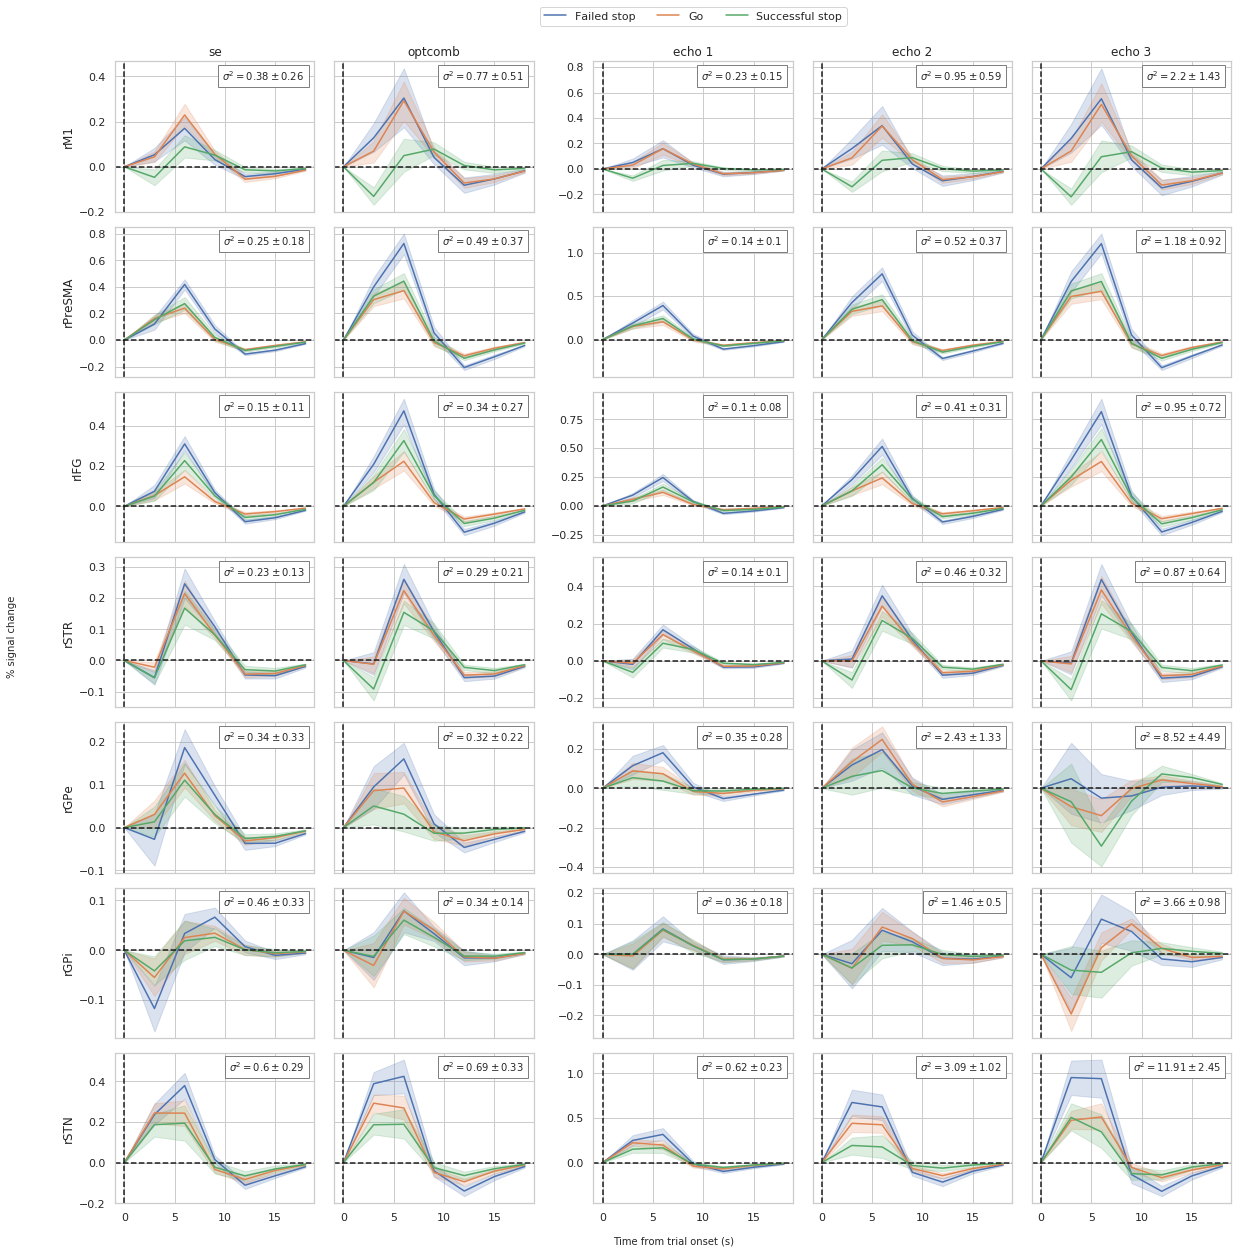

In [7]:
columns = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
plot_masks = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']

f, ax = make_plot(plot_dict=rfGroupsCwD['psc'],
                  y_label='% signal change',
                  columns=columns, 
                  masks=plot_masks, 
                  data_type='psc', 
                  oversample=1,
                  plot_type='first_level',
                  add_sigma2=True,
                  sharey=[(0, 1), (2, 3, 4)])

# Comparison of first-level $t$-values between protocols

In [8]:
import statsmodels.api as sm
import scipy as sp

def get_t_vals(rfGroup, data_type='se', contrast_type='first_level'):
    """ Extract t-values (PEs, PE variance) from rfGroup-object """
    contrasts = {}
    
    # Get regressor names, construct contrast vector
    X = rfGroup._get_response_fitters()[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    successful_stop_vs_baseline = (regressor_names == 'successful_stop_intercept_canonical_hrf').astype(int)
    failed_stop_vs_baseline = (regressor_names == 'failed_stop_intercept_canonical_hrf').astype(int)
    go_trial_vs_baseline = (regressor_names == 'go_trial_intercept_canonical_hrf').astype(int)
    
    if contrast_type == 'first_level':
        contrasts['Successful stop'] = successful_stop_vs_baseline
        contrasts['Failed stop'] = failed_stop_vs_baseline
        contrasts['Go'] = go_trial_vs_baseline
    else:
        contrasts['Failed stop - go'] = failed_stop_vs_baseline - go_trial_vs_baseline
        contrasts['Failed stop - successful stop'] = failed_stop_vs_baseline - successful_stop_vs_baseline
        contrasts['Successful stop - go'] = successful_stop_vs_baseline - go_trial_vs_baseline
    from pprint import pprint
    pprint(contrasts)

#         if data_type == 'se':
#             contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
#             contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
#             contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
#         else:
#             contrasts['Successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
#             contrasts['Failed stop'] =     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
#             contrasts['Go'] =              [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
#     else:
#         if data_type == 'se':
#             contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  0, 0, 1, 0]
#             contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, -1, 0, 1, 0]
#             contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0,  1, 0, 0, 0]
#         else:
#             contrasts['Failed stop - go'] =              [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0,  0, 0]
#             contrasts['Failed stop - successful stop'] = [0, 0, 0, 0, 0, 0, 0, 0,  0, 0, 1, 0, -1, 0]
#             contrasts['Successful stop - go'] =          [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,  1, 0]

    pes = []
    var_pes = []
    ts = []
    for c_name, c_vector in contrasts.items():
        pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='cope'))
        var_pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='varcope'))
        t = pe / np.sqrt(var_pe)
        
        pe['Event'] = c_name
        var_pe['Event'] = c_name
        t['Event'] = c_name
        
        pes.append(pe)
        var_pes.append(var_pe)
        ts.append(t)

    return pd.concat(pes), pd.concat(var_pes), pd.concat(ts)
    
def estimate_contrast(response_fitter, C, return_type='cope'):
    X = response_fitter.X
    ys = response_fitter.input_signal
    all_copes = []
    all_varcopes = []
    if ys.shape[1] > 1:
        for roi_idx, roi in enumerate(ys.columns):
#             print(roi)
            this_gls = response_fitter.gls_models[roi_idx]
            this_gls_res = response_fitter.gls_results[roi_idx]
            this_sigma2 = response_fitter
#             this_y = ys[roi].copy()
#             this_X = X.copy()
#             ols_resid = sm.OLS(this_y, this_X).fit().resid.values
#             resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
#             rho = resid_fit.params[1]  # this is our rho

#             # make V
#             order = sp.linalg.toeplitz(np.arange(len(this_y)))
#             V = rho ** order

#             gls = sm.GLS(this_y, this_X, sigma=V)
#             gls_res = gls.fit()
            
            # prewhitened design variance
            wX = this_gls.wexog
            XtXinv = np.linalg.pinv(np.dot(wX.T, wX))
            
            # error variance
            sigma2 = response_fitter.sigma2.values[roi_idx]
            
            # contrast
            cope = np.dot(C, this_gls_res.params)
            varcope = sigma2*np.dot(np.dot(C, XtXinv), C)
            

            all_copes.append(cope)
            all_varcopes.append(varcope)
            
            
            ## manually below
#             W = np.linalg.cholesky(np.linalg.pinv(V))

#             # whiten
#             this_X_w = np.dot(W, this_X)
#             this_y_w = np.dot(W, this_y)

#             # pes
#             XtXinv = np.linalg.pinv(np.dot(this_X_w.T, this_X_w))
#             XY = np.dot(this_X_w.T, this_y_w)
#             betas = np.dot(XtXinv, XY)

#             # copes
#             copes = np.dot(C, betas)

#             # var; get sigma^2 of the model
#             pred = this_X_w.dot(betas)
#             resid = this_y_w - pred

            # variance
#            XtXinv = np.linalg.pinv(np.dot(wX.T, wX))
#            e = this_y - gls_res.predict()
#            sigma2 = (np.dot(e.T, e)).sum()/(this_y.shape[0]-(this_X.shape[1]))
            #(np.dot(e.T, e)).sum()/(this_y.shape[0]-(this_X.shape[1]))  # sum of squared errors / (T - p)
#            varcope = sigma2*np.dot(np.dot(C, XtXinv), C)

#             varcope = sigma2*np.dot(np.dot(C, XtXinv), C)

#             all_copes.append(copes)
#             all_varcopes.append(varcope)
    if return_type == 'cope':
        return pd.Series(all_copes, index=ys.columns)
    elif return_type == 'varcope':
        return pd.Series(all_varcopes, index=ys.columns)

In [9]:
# get first-level t-values for the single echo, optimally combined multi echo data, and per echo
pe_se, var_se, t_se = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se')
pe_oc, var_oc, t_oc = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc')
pe_e1, var_e1, t_e1 = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1')
pe_e2, var_e2, t_e2 = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2')
pe_e3, var_e3, t_e3 = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3')

# Add name to data frames
t_se['Data'] = 'Single echo'
t_oc['Data'] = 'Multi echo (OC)'
t_e1['Data'] = 'Echo 1'
t_e2['Data'] = 'Echo 2'
t_e3['Data'] = 'Echo 3'

pe_se['Data'] = 'Single echo'
pe_oc['Data'] = 'Multi echo (OC)'
pe_e1['Data'] = 'Echo 1'
pe_e2['Data'] = 'Echo 2'
pe_e3['Data'] = 'Echo 3'

# Add contrasts
pe_se_contrast, var_se_contrast, t_se_contrast = get_t_vals(rfGroupsCwD['psc']['se'], data_type='se', contrast_type='contrast')
pe_oc_contrast, var_oc_contrast, t_oc_contrast = get_t_vals(rfGroupsCwD['psc']['optcomb'], data_type='oc', contrast_type='contrast')
pe_e1_contrast, var_e1_contrast, t_e1_contrast = get_t_vals(rfGroupsCwD['psc']['echo_1'], data_type='e1', contrast_type='contrast')
pe_e2_contrast, var_e2_contrast, t_e2_contrast = get_t_vals(rfGroupsCwD['psc']['echo_2'], data_type='e2', contrast_type='contrast')
pe_e3_contrast, var_e3_contrast, t_e3_contrast = get_t_vals(rfGroupsCwD['psc']['echo_3'], data_type='e3', contrast_type='contrast')

t_se_contrast['Data'] = 'Single echo'
t_oc_contrast['Data'] = 'Multi echo (OC)'
t_e1_contrast['Data'] = 'Echo 1'
t_e2_contrast['Data'] = 'Echo 2'
t_e3_contrast['Data'] = 'Echo 3'

pe_se_contrast['Data'] = 'Single echo'
pe_oc_contrast['Data'] = 'Multi echo (OC)'
pe_e1_contrast['Data'] = 'Echo 1'
pe_e2_contrast['Data'] = 'Echo 2'
pe_e3_contrast['Data'] = 'Echo 3'

# Concatenate everything into pd.DataFrames
pes = pd.concat([pe_se, pe_oc, pe_e1, pe_e2, pe_e3, pe_se_contrast, pe_oc_contrast, pe_e1_contrast, pe_e2_contrast, pe_e3_contrast])
t_vals = pd.concat([t_se, t_oc, t_e1, t_e2, t_e3, t_se_contrast, t_oc_contrast, t_e1_contrast, t_e2_contrast, t_e3_contrast])

# Make them "long" instead of "wide"
pes_long = pes.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='pe')
t_vals_long = t_vals.reset_index().melt(id_vars=['subject', 'Data', 'Event'], var_name='ROI', value_name='t')

pes_long.head()

{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'Go': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'Successful stop': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}
{'Failed stop - go':

,subject,Data,Event,ROI,pe
0,01,Single echo,Successful stop,ACC,0.062761
1,02,Single echo,Successful stop,ACC,0.265772
2,03,Single echo,Successful stop,ACC,0.352048
3,04,Single echo,Successful stop,ACC,0.082320
4,05,Single echo,Successful stop,ACC,0.426828


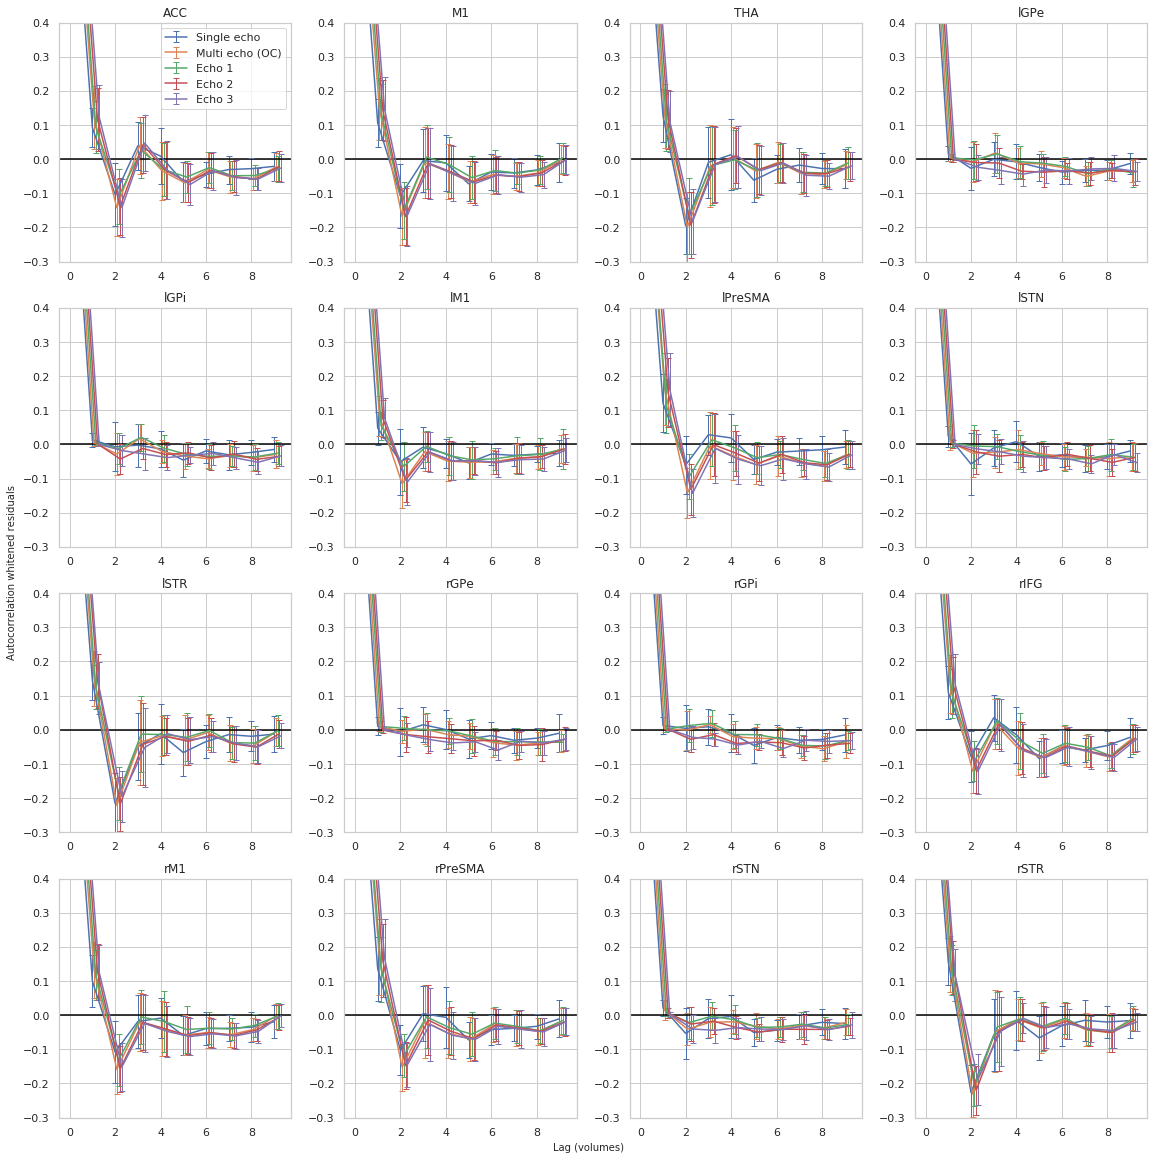

In [10]:
def acf(x, length=10):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

def residuals_acf(x, roi_idx=0, whitened_residuals=True):
    
    use_residuals = x._residuals.iloc[:,roi_idx].values
    if whitened_residuals:
        use_residuals = x.gls_models[roi_idx].cholsigmainv.dot(use_residuals)

    return pd.Series(acf(use_residuals), index=np.arange(10))

# get roi names
tmp = rfGroupsCwD['psc']['se']._get_response_fitters()[0]
roi_names = [x for x in tmp.input_signal.columns]

## plot
lags = np.arange(10)
f, axes = plt.subplots(nrows=4, ncols=4)
ses_lab_dict = {'se': 'Single echo', 'optcomb': 'Multi echo (OC)', 
                'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3'}
for i, ax in enumerate(axes.ravel()):
    ax.axhline(color='black')
    
    roi_name = roi_names[i]
    for ii, (ses, lab) in enumerate(ses_lab_dict.items()):
        resids_rho = rfGroupsCwD['psc'][ses]._get_response_fitters().apply(residuals_acf, roi_idx=i)
        mns = resids_rho.mean(axis=0)
        stds = resids_rho.std(axis=0)
        ax.errorbar(x=lags+.075*ii, y=mns, yerr=stds, capsize=3, elinewidth=1, label=lab)
    ax.set_title(roi_name)
    ax.set_ylim([-.3, .4])
    if i == 0:
        ax.legend()

f.text(0.5, 0, 'Lag (volumes)', ha='center', va='center')
f.text(0.00, 0.5, 'Autocorrelation whitened residuals', ha='center', va='center', rotation='vertical')

f.set_size_inches(16, 16)
f.tight_layout()
f.savefig('./figures/autocorrelation_whitened_residuals.pdf')

Since the remaining autocorrelation pattern does not seem to depend on the protocol / data type, this suggests (to me) that it's physiological autocorrelation. This also explains why there's minor differences in the remaining autocorrelation in lSTN (no signal / no physiological signal left in the later echos, so also no autocorrelation)

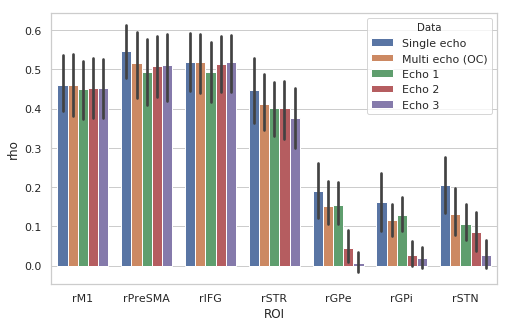

In [11]:
# what about rhos per ROI?
df = []
for ses, label in ses_lab_dict.items():
    rhos = rfGroupsCwD['psc'][ses]._get_response_fitters().apply(lambda x: pd.Series(x.rhos[:,0], index=roi_names))
    rhos = rhos.reset_index().melt(id_vars='subject', value_name='rho', var_name='ROI')
    rhos['Data'] = label
    df.append(rhos)
rhos = pd.concat(df)

sns.barplot(x='ROI', y='rho', hue='Data', data=rhos, order=['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN'])
plt.gcf().set_size_inches(8, 5)

# so yes there's some rho differences, again mainly in subcortical areas
# Speculatively, this is a consequence of the low tSNR of the later echoes in subcortical areas;
# most of the 'signal' is actually noise, which is pretty much white at the last echo.

# the residual autocorrelation appears to be related to "signal" (something physiological?)

### correlations between residuals of different echoes 

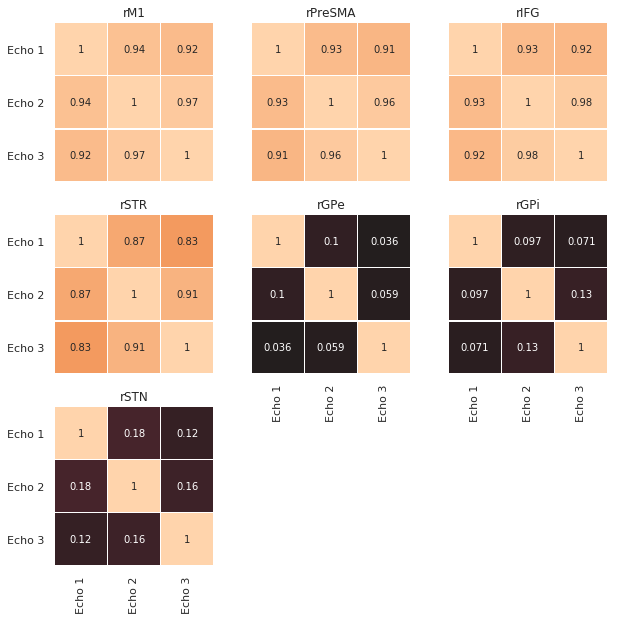

In [12]:
f, axes = plt.subplots(3, 3)
axes = axes.ravel()
## variance-covariance matrix of residuals of echos
for i, roi in enumerate(['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN']):
    roi_idx = np.where(np.array(roi_names) == roi)[0][0]
    whitened_residuals1 = rfGroupsCwD['psc']['echo_1']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))
    whitened_residuals2 = rfGroupsCwD['psc']['echo_2']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))
    whitened_residuals3 = rfGroupsCwD['psc']['echo_3']._get_response_fitters().apply(lambda rf: rf.gls_models[roi_idx].cholsigmainv.dot(rf._residuals.iloc[:,roi_idx]))

    residual_df = pd.concat([whitened_residuals1, whitened_residuals2, whitened_residuals3], axis=1)
    corrmat = residual_df.apply(lambda x: np.corrcoef(np.vstack([x[0], x[1], x[2]])), axis=1).mean(axis=0)
    corrmat = pd.DataFrame(corrmat, index=['Echo 1', 'Echo 2', 'Echo 3'], columns = ['Echo 1', 'Echo 2', 'Echo 3'])
    sns.heatmap(corrmat, ax=axes[i], vmax=1, center=0, square=True, linewidths=.5, 
                cbar_kws={"shrink": .5}, annot=True, cbar=False)
    if i < 4:
        axes[i].tick_params(axis='x',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False,         # ticks along the top edge are off
                            labelbottom=False) # labels along the 
    if i not in [0, 3, 6]:
        axes[i].tick_params(axis='y',          # changes apply to the x-axis
                            which='both',      # both major and minor ticks are affected
                            bottom=False,      # ticks along the bottom edge are off
                            top=False,
                            left=False,
                            labelleft=False) # labels along the
    axes[i].set_title(roi)
    
axes[-2].grid('Off')
axes[-1].grid('Off')
axes[-1].axis('off')
axes[-2].axis('off')
f.set_size_inches(10, 10)

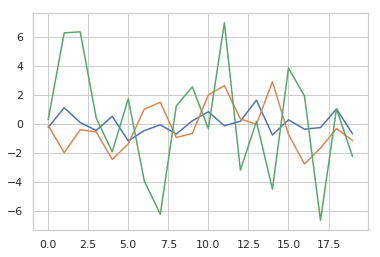

In [13]:
# example plot of residuals for first subject
plt.plot(residual_df.iloc[0][0][:20])
plt.plot(residual_df.iloc[0][1][:20])
plt.plot(residual_df.iloc[0][2][:20])